# User acquisition analytics

In this notebook we are going to embed our user data in order to draw relevant conclusions our user acquisition.

Recently we have run 2 campaings - an older one at the end of August, and a more recent one right before Christmas, 2023. The first campaign operated with more generic messages, while the latter one was aided by XYZCr$$d, a made up influencer.

In terms of user data, we have 
1. the ad creative the users clicked on
2. the signup date as a unix timestamp
3. and the average daily activity (measured in API calls / day)

Embedding those inputs in a vectorspace allows us to cluster them and find meaningful user groups.

To understand the embeddings we will
- create a UMAP visualisation
- and examine the cluster labels' association with initial features

## Boilerplate

### Installation

In [1]:
%pip install superlinked==9.19.1
%pip install umap-learn

### Imports and constants

In [2]:
from datetime import datetime, timedelta
import os

import altair as alt
import numpy as np
import pandas as pd
from sklearn.cluster import HDBSCAN
import umap

from superlinked.evaluation.charts.recency_plotter import RecencyPlotter
from superlinked.evaluation.vector_sampler import VectorSampler
from superlinked.framework.common.dag.context import CONTEXT_COMMON, CONTEXT_COMMON_NOW
from superlinked.framework.common.dag.period_time import PeriodTime
from superlinked.framework.common.embedding.number_embedding import Mode
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import String, Float, Timestamp
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
    InMemoryApp,
)
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.number_space import NumberSpace
from superlinked.framework.dsl.space.recency_space import RecencySpace

alt.renderers.enable("mimetype")
alt.data_transformers.disable_max_rows()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
pd.set_option("display.max_colwidth", 190)
pd.options.display.float_format = "{:.2f}".format

In [3]:
USER_DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-user-acquisiton-analytics/user_acquisiton_data.csv"
NOW_TS = 1708529056
EXECUTOR_DATA = {CONTEXT_COMMON: {CONTEXT_COMMON_NOW: NOW_TS}}

## Read and explore dataset

In [4]:
NROWS = os.getenv("NOTEBOOK_TEST_ROW_LIMIT", None)
NROWS = NROWS if NROWS is None else int(NROWS)
user_df: pd.DataFrame = pd.read_csv(USER_DATASET_URL, nrows=NROWS)
print(f"User data dimensions: {user_df.shape}")
user_df.head()

User data dimensions: (8000, 4)


id  signup_date  \
0   0   1693044869   
1   1   1694581577   
2   2   1693557423   
3   3   1693313203   
4   4   1692863645   

                                                                                                                                                     ad_creative  \
0  Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!   
1                                                                       Join a thriving gaming community and challenge your skills against formidable opponents!   
2                                        Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!   
3                                        Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!   
4  Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!   

   activity  
0      0.30  
1      1.14  
2      0.01  
3      0.30  
4      0.12

In [5]:
# The influencer backed message seem to work a lot better.
pd.DataFrame(user_df["ad_creative"].value_counts())

count
ad_creative                                                                                                                                                         
Unleash your gaming potential! Upgrade to premium for 2 months free and dominate the competition with XYZCr$$d!                                                 1785
Ready to level up? Join XYZCr$$d now for intense gaming battles and exclusive rewards!                                                                          1312
Embark on your gaming journey with XYZCr$$d! Join now and experience the thrill of competing against the finest players worldwide!                               715
Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!    671
Step into the arena of endless possibilities! Join now to engage in exhilarating gaming competitions and forge friendships with fellow gamers along the way!     541
Calling all gamers! Don't miss out on your chance to excel. Join XYZCr$$d today for unparalleled gaming excitement and endless challenges!                       533
Join a thriving gaming community and challenge your skills against formidable opponents!                                                                         501
Elevate your gaming experience! Upgrade now for 2 months free premium access and immerse yourself in the ultimate gaming community of XYZCr$$d!                  501
Seeking thrilling gaming adventures? Join our community of gamers and embark on epic quests against worthy adversaries!                                          452
Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!                                          347
Enter the realm of gaming excellence! Join our vibrant community and compete against some of the most skilled players worldwide!                                 343
Become a gaming legend! Join XYZCr$$d now and test your skills against top-tier players from around the globe. Upgrade to premium for 2 months free!             299

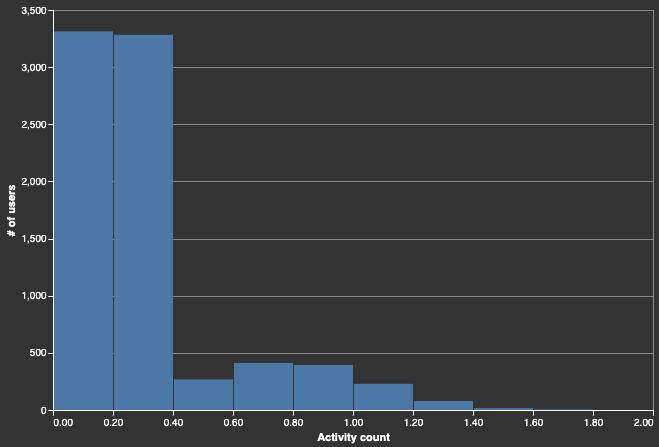

In [6]:
# The distribution of activity shows a 2-mode distribution - possibly in connection with the two campaings for user acquisition as newer users
# did not have time to accumulate activity like older users. Also this informs NumberSpace parameters
alt.Chart(user_df).mark_bar().encode(
    alt.X("activity:Q", bin=True, title="Activity count"),
    alt.Y("count()", title="# of users"),
).properties(width=600, height=400)

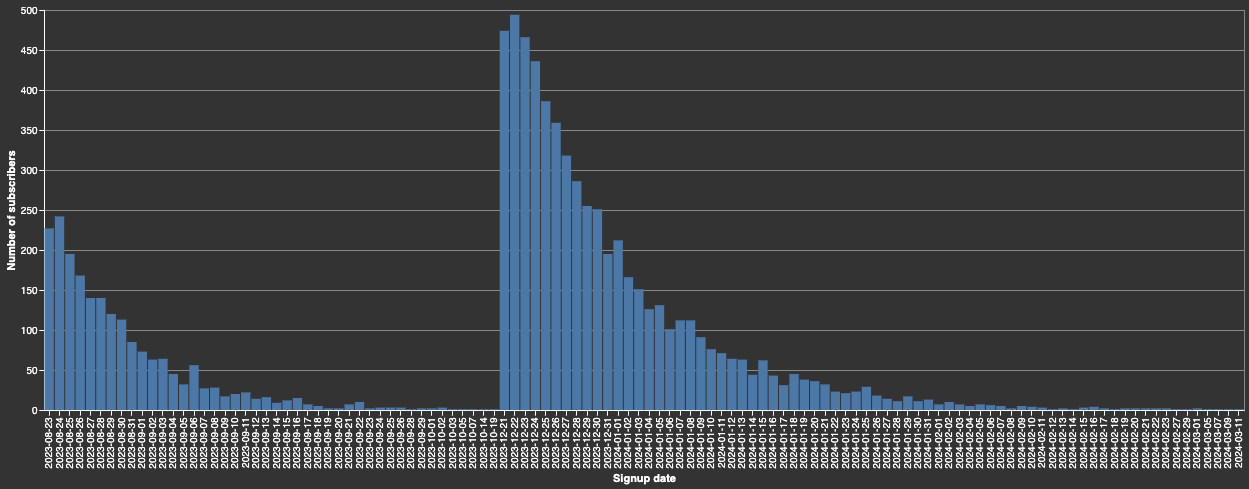

In [7]:
# new users per signup date - further confirms the second campaign working great
# note the jump from 2023-10-19 to 2023-12-21 at the spike - we only deal with campaign data
# also this suggests we need 2 period times to handle the two campaings properly - 65 and 185 days seem fine.
dates: pd.DataFrame = pd.DataFrame(
    {"date": [str(datetime.fromtimestamp(ts).date()) for ts in user_df["signup_date"]]}
)
dates_to_plot = pd.DataFrame(dates.value_counts(), columns=["count"]).reset_index()
alt.Chart(dates_to_plot).mark_bar().encode(
    alt.X("date", title="Signup date"), alt.Y("count", title="Number of subscribers")
).properties(height=400, width=1200)
# we have 8k users, roughly 2k subscribed with the first push, 6k with the second. Maybe the second push brought in subscribers intrinsically,
# but also through spillover to old ads as well - will see that by the ad creatives

## Set up Superlinked

In [8]:
@schema
class UserSchema:
    ad_creative: String
    activity: Float
    signup_date: Timestamp
    id: IdField

In [9]:
user = UserSchema()

In [10]:
# embed the creatives in a semantic space to inform the model about which creative hooked the user
# the representation is also useful as it gives the opportunity to group similar meaning ad creatives
creative_space = TextSimilaritySpace(
    text=user.ad_creative, model="sentence-transformers/all-mpnet-base-v2"
)
# encode activity for the relevant range with similar mode (btw any other mode could work just for this here)
activity_space = NumberSpace(
    number=user.activity, mode=Mode.SIMILAR, min_value=0.0, max_value=1.0
)
# encode signup date so the clustering can take this into account
recency_space = RecencySpace(
    timestamp=user.signup_date,
    period_time_list=[PeriodTime(timedelta(days=65)), PeriodTime(timedelta(days=185))],
    negative_filter=0.0,
)

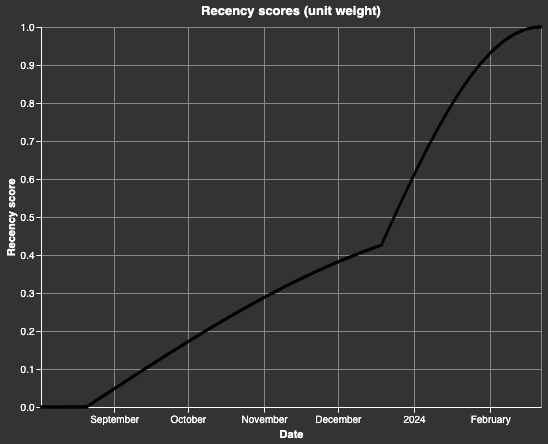

In [11]:
# this plot helps us understanding our recency scores
recency_plotter = RecencyPlotter(recency_space, context_data=EXECUTOR_DATA)
recency_plotter.plot_recency_curve()

In [12]:
user_index = Index(spaces=[creative_space, activity_space, recency_space])

In [13]:
user_df_parser = DataFrameParser(schema=user)

In [14]:
source_user: InMemorySource = InMemorySource(user, parser=user_df_parser)
executor: InMemoryExecutor = InMemoryExecutor(
    sources=[source_user], indices=[user_index], context_data=EXECUTOR_DATA
)
app: InMemoryApp = executor.run()

In [15]:
source_user.put([user_df])

Taking long? You are welcome to take a look at [VectorHub](https://hub.superlinked.com/), Superlinked's educational space about our shared passion: vectors.

## Load features

In [16]:
# collect all vectors from the app
vs = VectorSampler(app=app)
vector_collection = vs.get_all_vectors(user_index, user)
vectors = vector_collection.vectors
vector_df = pd.DataFrame(vectors, index=[int(id_) for id_ in vector_collection.id_list])
vector_df.head()

0    1     2    3     4     5     6    7     8     9    ...   766  \
1992 -0.05 0.02 -0.01 0.01  0.01  0.00 -0.04 0.01  0.01 -0.01  ... -0.02   
252   0.00 0.03 -0.02 0.03  0.03  0.01 -0.04 0.01  0.00  0.03  ...  0.03   
2691 -0.03 0.03 -0.01 0.01  0.01  0.00 -0.02 0.02 -0.01  0.02  ...  0.01   
2816  0.00 0.02 -0.02 0.02  0.01 -0.01 -0.04 0.01 -0.01  0.01  ... -0.00   
2848 -0.00 0.05  0.02 0.01 -0.00  0.01 -0.01 0.01 -0.01  0.02  ...  0.02   

       767  768  769  770   771   772   773   774  775  
1992 -0.00 0.28 0.57 0.00  0.00  0.00 -0.38 -0.24 0.00  
252   0.00 0.17 0.61 0.00  0.00  0.00 -0.37 -0.26 0.00  
2691 -0.01 0.30 0.49 0.00 -0.16 -0.38  0.01 -0.41 0.00  
2816 -0.00 0.17 0.55 0.00 -0.18 -0.37  0.00 -0.41 0.00  
2848  0.01 0.21 0.54 0.00 -0.16 -0.37  0.01 -0.41 0.00  

[5 rows x 776 columns]

In [17]:
vector_df.shape

(8000, 776)

## Clustering

In [18]:
# fit a clustering model
# this is done after some basic parameter search - not the point of this notebook
hdbscan = HDBSCAN(min_cluster_size=500, metric="cosine")
hdbscan.fit(vector_df.values)

HDBSCAN(metric='cosine', min_cluster_size=500)

In [19]:
# create label df
label_df = pd.DataFrame(
    hdbscan.labels_, index=vector_df.index, columns=["cluster_label"]
)
# number of users in clusters
label_df["cluster_label"].value_counts()

cluster_label
-1    2668
 1    1926
 0    1511
 3    1090
 2     805
Name: count, dtype: int64

### Visualize

In [21]:
# fit UMAP and transform dataset
umap_transform = umap.UMAP(random_state=0, transform_seed=0, n_jobs=1, metric="cosine")
umap_transform = umap_transform.fit(vector_df)
umap_vectors = umap_transform.transform(vector_df)
umap_df = pd.DataFrame(
    umap_vectors, columns=["dimension_1", "dimension_2"], index=vector_df.index
)
umap_df = umap_df.join(label_df)

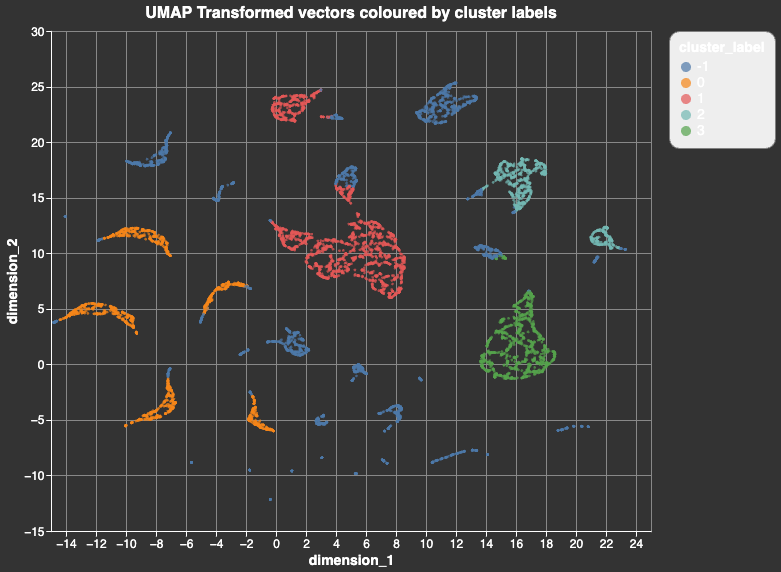

In [22]:
alt.Chart(umap_df).mark_circle(size=8).encode(
    x="dimension_1", y="dimension_2", color="cluster_label:N"
).properties(
    width=600, height=500, title="UMAP Transformed vectors coloured by cluster labels"
).configure_title(
    fontSize=16,
    anchor="middle",
).configure_legend(
    strokeColor="gray",
    fillColor="#EEEEEE",
    padding=10,
    cornerRadius=10,
    labelFontSize=14,
    titleFontSize=14,
).configure_axis(
    titleFontSize=14, labelFontSize=12
)

We can see our clusters are visually separated. The dark blue ones are outliers (the visible dark blue groups are not large/dense enough to form their own cluster). The frequent presence of blobs is due to the limited number of ad_creatives that constitute 1/3 of all vector norm mass.

Some clusters are somewhat scattered around—this is a weakness of 2-D representations created by UMAP.

### Understand clusters

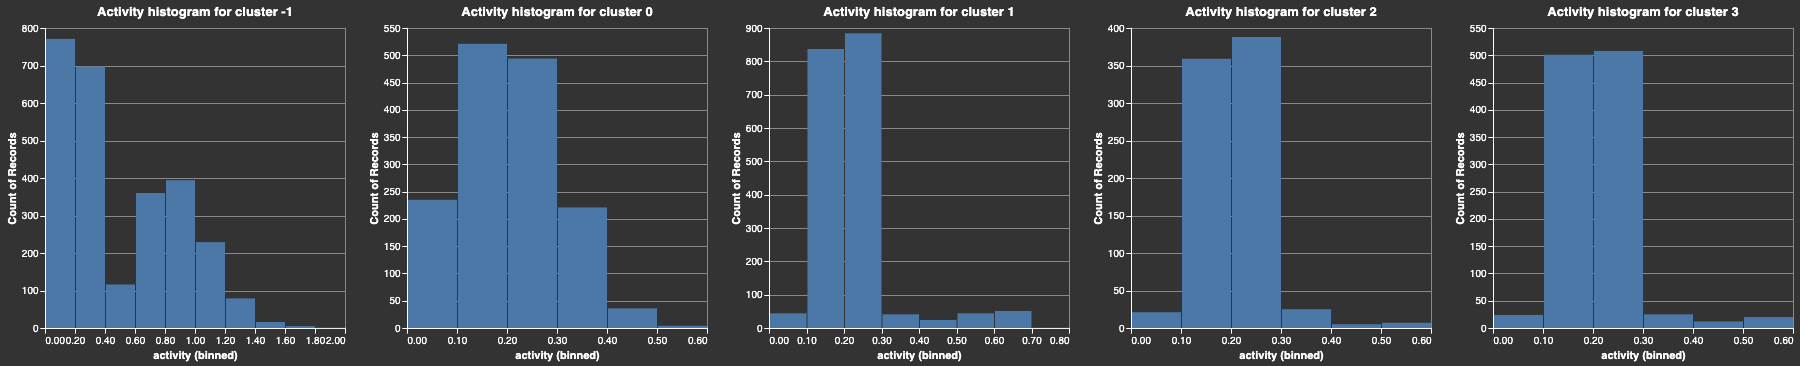

In [24]:
# activity histograms by cluster
user_df = user_df.set_index("id").join(label_df)

by_cluster_data = {
    label: user_df[user_df["cluster_label"] == label]
    for label in np.unique(hdbscan.labels_)
}

activity_histograms = [
    alt.Chart(user_df_part)
    .mark_bar()
    .encode(x=alt.X("activity", bin=True), y="count()")
    .properties(title=f"Activity histogram for cluster {label}")
    for label, user_df_part in by_cluster_data.items()
]

alt.hconcat(*activity_histograms)

Activity profile of clusters:
- outliers are the most active relatively - active users are rare
- cluster 2-3 are quite similar, positive, but low activity users
- cluster 0 has the highest proportion of medium active users
- cluster 1 has active users who are not outliers and a fairly balanced activity profile

In [25]:
pd.DataFrame(user_df.groupby("cluster_label")["ad_creative"].value_counts())

count
cluster_label ad_creative                                                                                                                                                         
-1            Calling all gamers! Don't miss out on your chance to excel. Join XYZCr$$d today for unparalleled gaming excitement and endless challenges!                       533
              Seeking thrilling gaming adventures? Join our community of gamers and embark on epic quests against worthy adversaries!                                          452
              Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!    330
              Unleash your gaming potential! Upgrade to premium for 2 months free and dominate the competition with XYZCr$$d!                                                  266
              Ready to level up? Join XYZCr$$d now for intense gaming battles and exclusive rewards!                                                                           222
              Join a thriving gaming community and challenge your skills against formidable opponents!                                                                         174
              Step into the arena of endless possibilities! Join now to engage in exhilarating gaming competitions and forge friendships with fellow gamers along the way!     152
              Embark on your gaming journey with XYZCr$$d! Join now and experience the thrill of competing against the finest players worldwide!                               126
              Enter the realm of gaming excellence! Join our vibrant community and compete against some of the most skilled players worldwide!                                 122
              Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!                                          114
              Elevate your gaming experience! Upgrade now for 2 months free premium access and immerse yourself in the ultimate gaming community of XYZCr$$d!                   94
              Become a gaming legend! Join XYZCr$$d now and test your skills against top-tier players from around the globe. Upgrade to premium for 2 months free!              83
 0            Step into the arena of endless possibilities! Join now to engage in exhilarating gaming competitions and forge friendships with fellow gamers along the way!     389
              Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!    341
              Join a thriving gaming community and challenge your skills against formidable opponents!                                                                         327
              Experience the rush of competitive gaming! Join now to connect with fellow gamers and test your mettle in epic battles!                                          233
              Enter the realm of gaming excellence! Join our vibrant community and compete against some of the most skilled players worldwide!                                 221
 1            Unleash your gaming potential! Upgrade to premium for 2 months free and dominate the competition with XYZCr$$d!                                                 1519
              Elevate your gaming experience! Upgrade now for 2 months free premium access and immerse yourself in the ultimate gaming community of XYZCr$$d!                  407
 2            Embark on your gaming journey with XYZCr$$d! Join now and experience the thrill of competing against the finest players worldwide!                               589
              Become a gaming legend! Join XYZCr$$d now and test your skills against top-tier players from around the globe. Upgrade to premium for 2 months free!             216
 3            Ready to level up? Join XYZCr$$d now for i

In terms of ad_creatives:
- outliers have creatives from both campaigns(as expected)
- cluster 3 contains only 1, 0 and 2 only 2 distinct influencer based creative, 
- cluster 1 has both influencer and non-influencer creatives, but non influencer ones are was more frequent.

In [26]:
user_df["signup_datetime"] = [
    datetime.fromtimestamp(ts) for ts in user_df["signup_date"]
]
desc = user_df.groupby("cluster_label")["signup_datetime"].describe()
for col in desc.columns:
    if col == "count":
        continue
    desc[col] = [dt.date() for dt in desc[col]]
desc

count        mean         min         25%         50%  \
cluster_label                                                         
-1             2668  2023-12-09  2023-08-23  2023-12-22  2023-12-26   
 0             1511  2023-08-30  2023-08-23  2023-08-25  2023-08-28   
 1             1926  2023-12-30  2023-12-21  2023-12-24  2023-12-28   
 2              805  2023-12-29  2023-12-21  2023-12-24  2023-12-27   
 3             1090  2023-12-30  2023-12-21  2023-12-24  2023-12-28   

                      75%         max  
cluster_label                          
-1             2024-01-03  2024-03-11  
 0             2023-09-01  2023-10-19  
 1             2024-01-03  2024-02-10  
 2             2024-01-02  2024-01-27  
 3             2024-01-04  2024-01-31

In terms of signup date:
- outliers are scattered as usual
- 1 is mostly from the first campaign, 1/4 from the second too
- 0, 2 and 3 are from the new campaign only

## Summary
<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;}
.tg td{background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-abip{background-color:#f9f9f9;border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-btxf{background-color:#f9f9f9;border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-fymr">Cluster label</th>
    <th class="tg-fymr">Activity</th>
    <th class="tg-fymr">Ad creatives</th>
    <th class="tg-fymr">Signup date <br>(campaign)</th>
    <th class="tg-fymr"># Users</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-abip">-1 (outliers)</td>
    <td class="tg-btxf">all (mostly active)</td>
    <td class="tg-btxf">all</td>
    <td class="tg-btxf">all</td>
    <td class="tg-btxf">1088<br></td>
  </tr>
  <tr>
    <td class="tg-c3ow">0</td>
    <td class="tg-0pky">medium active users</td>
    <td class="tg-0pky">2 specific influencer creatives</td>
    <td class="tg-0pky">only new</td>
    <td class="tg-0pky">2178</td>
  </tr>
  <tr>
    <td class="tg-abip">1</td>
    <td class="tg-btxf">balanced with non-outlier extremely active users</td>
    <td class="tg-btxf">both influencer and non-influencer creatives, but non-influencer ones are way more frequent"</td>
    <td class="tg-btxf">mostly old, some new</td>
    <td class="tg-btxf">2839</td>
  </tr>
  <tr>
    <td class="tg-c3ow">2</td>
    <td class="tg-0pky">positive, but low activity</td>
    <td class="tg-0pky">2 specific influencer creatives</td>
    <td class="tg-0pky">only new</td>
    <td class="tg-0pky">805</td>
  </tr>
  <tr>
    <td class="tg-abip">3</td>
    <td class="tg-btxf">positive, but low activity</td>
    <td class="tg-btxf">1 specific influencer creatives</td>
    <td class="tg-btxf">only new</td>
    <td class="tg-btxf">1090</td>
  </tr>
</tbody>
</table>